EE 502 P: Analytical Methods for Electrical Engineering
# 9. Machine Learning, Part I
## Prof. Eric Klavins, Electrical and Computer Engineering
### 25 September, 2019
Copyright &copy; 2019, University of Washington

In [3]:
import math
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

# Note to serve slides do
# jupyter nbconvert 9.ML.ipynb --to slides --post serve

# What is ML?

## Classification

A **classifier** is a function

$$y = f^*(x)$$

that takes an input $x$, usually a high dimensional vector, to an output $y$ that represents the category into which $x$ falls. For example, $x$ might be an image of an animal and $y$ the kind of animal (cat, dog, mouse, ...).

The goal of ML in this case is to define a function 

$$y = f(x;\theta)$$

with parameter vector $\theta$ and then solve or approximate

$$\min_\theta L \left  [ \; f(x;\theta), f^*(\theta) \right ] $$

where $L$ is called a **loss function** that is usually designed to be zero when $f$ and $f^*$ agree.

Typically, $\theta$ is found by fitting **training data** $x_1, x_2, ..., $ that has been labeled by hand to find categories $y_1, y_2, ...$. 

## Classification Examples

* Classify images based on what animals are in them.
* Classify electrocariograms by whether a heart attack is imminent or not.
* Classify weather patterns to predict whether a tornado is likely soon.

To work, these problems need lots (1000s) of labeled (by people) examples.

## Generation

Let $x_1, x_2, ..., $ be a set of data, such as images, that possibly fall into a number of unknown categories. The goal of **generation** is to 

a) Discover categories in which the data are clustered;

b) Generate a new $x$ that falls into given category, or transform a datum $x$ from one category into another.

**Generative Learning** learns a function that can generate such new values of $x$. 

## Generation Examples

* Given a blurry or damaged image, produce a new verion of the image that is sharp and clean.
* Produce realistic animated walking, running, jumping, talking, ...
* See what you might look like younger, or older, or with a different hair color.
* Compose music in a certain style.
* Produce images in the style of a given painter.
* Simulate statements politicians (yikes!).

To work, these problems need lots of examples, although they do not need to be labeled.

# The Variational Autoencoder (VAE)

<img src="http://kvfrans.com/content/images/2016/08/vae.jpg" width=80%>

* Sampling from the latent space allows you to generate completely new images.
* Clustering the latent space gives you low dimensional encodings of image space.
* Adding the cluster "glasses" to the cluster "men without glasses" would allow you to generate images of men with glasses, etc.


## Decision and Control

Suppose we have a set of states and a set of actions. When an action $a$ is applied to a state $s$ the result is a new state $s'$ and a reward $r$. The actions are generally probabilistic, meaning that one has to talk about 

$$
P[S_{k+1} = s' \;|\; S_k = s, \; A_k = a]
$$

and the rewards are probabilistic as well, so that we have to use

$$
P[R_{k+1} = r \;|\; S_{k+1} = s', \; S_k = s, \; A_k = a].
$$

The **decision and control** problem is to define a **policy** $\phi(a,s)$ that says what the probability of taking action $a$ should be in in state $s$. The optimal policy is one that returns the most reward over time.

**Reinforcement Learning** is the process of learning and optimal $\phi$ by gathering data from experiments in which various actions are taken at various steps. 

## Decision and Control Examples

* Control a robot to walk, run, hop, etc.
* Play video games (usually a lot better than people).
* Play games like go and chess (definitely a lot better than people).

To do these problems, you need to be able to try many experiments over and over to get significant coverage of the action $\times$ state space. 

# Neural Network Basics

## Learning XOR

Suppose we have the goal of learning the XOR function

$$
f^*(x) = \left \{
\begin{array}{ll}
1 & \mathrm{if} \; x_1 \neq x_2 \\
0 & \mathrm{else} 
\end{array}
\right .
$$

from data of the form

| $x_1$ | $x_2$ | $y$ |
|---|---|---|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

Given a model $f(x;\theta)$ then we might wish to minimize the *mean square error*:

$$
J(\theta) = \frac{1}{4} \sum_{x} \left ( f^*(x) - f(x,\theta) \right )^2 .
$$

<p style="font-size: 8pt">This material adapted from Goodfellow page 187.</p>

## A Linear Model

Let $f(x,\theta) = w^T x + b$ where $w^T = ( w_1 \; w_2 )$ and $b$ is a scalar.

Here, the parameters are $\theta = (w_2\;w_2\;b)$. 

Minimizing $J(\theta)$ amounts to minimizing 

\begin{eqnarray}
J(\theta) & = & 
\frac{1}{4}
\left [
\left ( 0 - (w_1 \; w_2)\begin{pmatrix}0 \\ 0 \end{pmatrix} - b \right )^2
\right . \\
& = & \left ( 1 - (w_1 \; w_2)\begin{pmatrix}0 \\ 1 \end{pmatrix} - b \right )^2\\
& = & \left ( 1 - (w_1 \; w_2)\begin{pmatrix}1 \\ 0 \end{pmatrix} - b \right )^2\\
& = & 
\left .
\left (0 -  (w_1 \; w_2)\begin{pmatrix}1 \\ 1 \end{pmatrix} - b \right )^2 \; \right ].
\end{eqnarray}

Minimizing this expression gives $w = 0$ and $b = \frac{1}{2}$. Thus, the linear model always outputs $1/2$, which is not very good.

**This is the best a linear model can do &#x2639;**

## Feedforward Neural Networks

**Def:** A **Feedforward Neural Network** is a directed acyclic graph $N = (V,E)$ with the following additional structure. 
- An **edge weight** function $w: E \rightarrow \mathbb{R}$. 
- A **bias function** $b : V \rightarrow \mathbb{R}.$
- A set of **input nodes**: $U \subset V$.
- A set of **output nodes**: $\mathcal{O} \subset V$.

For example:
<img src="images/xor-network.jpeg" width=50%>

## Network Computation

A network can be divided into layers that perform successive computations on the input layer. The previous network has two layers that compute as follows:

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g \left ( 
    \begin{pmatrix}
      w_{13} & w_{23} \\
      w_{14} & w_{24}
    \end{pmatrix}
      \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} 
    + \begin{pmatrix}b_3 \\ b_4\end{pmatrix} 
\right )
$$

and

$$
x_5 = 
g \left ( 
      \begin{pmatrix} w_{35} & w_{45} \end{pmatrix}
      \begin{pmatrix} x_3 \\ x_4 \end{pmatrix} 
    + b_5 
\right )
$$

with 

$y = x_5$ being the output. This can be rewritten as

$$
y = f(x,\theta) = g(w^Tg(W^Tx + b) + c)
$$

where $x$ (no subscript) is just $(x_1 \; x_2)^T$. 

Here, $g$ is some nonlinear function. It used to be that common forms for $g$ were sigmoids or $\tanh$. However, it was eventually discovered that the **rectified linear unit** was faster computationally, and nonlinear enough.

$$
g(x) = \left \{
\begin{array}{ll}
x & \mathrm{if} \; x > 0 \\
0 & \mathrm{otherwise} .
\end{array}
\right .
$$

## XOR with a Feedforward Neural Network

Let 

$$
\begin{pmatrix}
  w_{13} & w_{23} \\
  w_{14} & w_{24}
\end{pmatrix} = \begin{pmatrix}
  1 & 1 \\
  1 & 1
\end{pmatrix}, \;\; \begin{pmatrix}
  b_3 \\
  b_4
\end{pmatrix} = \begin{pmatrix}
  0 \\
  -1
\end{pmatrix}
$$

and

$$
\begin{pmatrix}
  w_{35} \\
  w_{45} 
\end{pmatrix} = \begin{pmatrix}
  1 \\
  -2 \end{pmatrix}, \;\; b_5 = 0 .
$$

---

On the input $(0 \; 1)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g \left ( 
    \begin{pmatrix}
        1 & 1 \\
        1 & 1
    \end{pmatrix}
      \begin{pmatrix} 0 \\ 1 \end{pmatrix} 
    + \begin{pmatrix} 0 \\ -1\end{pmatrix} 
\right ) = g \begin{pmatrix} 1 \\ 0 \end{pmatrix} 
         = \begin{pmatrix} 1 \\ 0 \end{pmatrix} 
$$

and the second layer computes 

$$
x_5 = 
g \left ( 
      \begin{pmatrix} 1 & -2 \end{pmatrix}
      \begin{pmatrix} 1 \\ 0 \end{pmatrix} 
    + 0
\right ) = g(1) = 1 .
$$

---

While on the input $(0 \; 0)^T$ the first layer of the network computes

$$
\begin{pmatrix} x_3 \\ x_4 \end{pmatrix} = 
g \left ( 
    \begin{pmatrix}
        1 & 1 \\
        1 & 1
    \end{pmatrix}
      \begin{pmatrix} 0 \\ 0 \end{pmatrix} 
    + \begin{pmatrix} 0 \\ -1\end{pmatrix} 
\right ) = g \begin{pmatrix} 0 \\ -1 \end{pmatrix} 
         = \begin{pmatrix} 0 \\ 0 \end{pmatrix} 
$$

and the second layer computes 

$$
y = x_5 = 
g \left ( 
      \begin{pmatrix} 1 & -2 \end{pmatrix}
      \begin{pmatrix} 0 \\ 0 \end{pmatrix} 
    + 0
\right ) = g(0) = 0 .
$$

Of course, for more complex problems we need a system to **learn** these values for $W$ and $w$. 

## Representing NNs with pytorch

There are several Neural Network packages for Python available. We'll use the one called `pytorch` which was developed by Facebook and is available [here](https://pytorch.org/). At the top of this notebook we included this library with
```python
import torch
import torch.nn as nn
import torch.nn.functional as F
```

In [116]:
# First, we define a class that returns a neural network with
# two fully connected layers

class Model(nn.Module):
    def __init__(self,size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(2,size)
        self.fc2 = nn.Linear(size,1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
    
# We can then make a new network of this class with

model = Model(2)

# And see the randomly assigned parameters with

model.fc1.weight.data, model.fc1.bias.data, \
model.fc2.weight.data, model.fc2.bias.data

# Note that tensors are somewhat like numpy arrays.

(tensor([[-0.0377,  0.0772],
         [-0.1013,  0.2192]]),
 tensor([ 0.6898, -0.3705]),
 tensor([[0.5433, 0.6269]]),
 tensor([0.6967]))

In [117]:
# To compute with this model, we can do

y00 = model(torch.tensor([
    [0,0]
],dtype=torch.float))

print(y00)

# Or on all inputs

y = model(torch.tensor([
    [0,0],
    [0,1],
    [1,0],
    [1,1],
],dtype=torch.float))

print(y)

# Note the torch.float datatype is required. Torch is very picky about datatypes matching
# between inputs and the layers.

# Also note that the default parameters do not compute the XOR function very well!

tensor([[1.0715]], grad_fn=<ReluBackward0>)
tensor([[1.0715],
        [1.1134],
        [1.0510],
        [1.0930]], grad_fn=<ReluBackward0>)


In [119]:
# Reassign the weights and biases to get XOR

model.fc1.weight.data = torch.tensor([[1,1],[1,1]],dtype=torch.float)
model.fc1.bias.data = torch.tensor([0,-1],dtype=torch.float)
model.fc2.weight.data = torch.tensor([[1,-2]],dtype=torch.float)
model.fc2.bias.data = torch.tensor([0],dtype=torch.float)

y = model(torch.tensor([
    [0,0],
    [0,1],
    [1,0],
    [1,1],
],dtype=torch.float))

print(y)

tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<ReluBackward0>)


## Training a NN

"Learning" in neural networks basically means

- Computing the gradient of $J(\theta)$ with respect to $\theta$
- Using a nonlinear optimizer to minimize $J$

As an example, consider the XOR network. Let's rewrite the function as

$$
y = f(x,\theta) = g(w^Tg(W^Tx + b) + c)
$$

where $W$ is the matrix of weights in the first layer, $b$ is the bias vector of the first layer, $w$ is the vector of weights in the second layer, and $c$ is the bias of the second layer. 

Suppose we have a cost function of the form

$$
J(\theta) = \frac{1}{4} \sum_{x} \left ( f^*(x) - f(x,\theta) \right )^2
$$

where $\theta = (W,w,b,c)$. We wish to obtain

$$
\nabla_\theta J(\theta).
$$

This can be computed using the chain rule. For example, for $b$, 

\begin{eqnarray}
\frac{\partial J}{\partial{b}}(\theta) 
& = & \frac{1}{2} \sum_x \left ( f^*(x) - \frac{\partial}{\partial b} g(w^Tg(W^Tx + b) + c) \right ) \\
& = & \frac{1}{2} \sum_x \left ( f^*(x) - 
\left ( 
w^T \frac{\partial}{\partial b} (W^Tx+b)g'(W^Tx+b)
\right ) g' \left (
w^Tg(W^Tx + b) + c
\right )
\right ) \\
& = & \frac{1}{2} \sum_x  \left ( f^*(x) - 
w^T  g'(W^Tx+b) g' \left (
w^Tg(W^Tx + b) + c
\right )
\right )
\end{eqnarray}

where 

$$
g'(x) = \left \{
\begin{array}{ll}
1 & \mathrm{if} \; x \geq 0 \\
0 & \mathrm{otherwise} .
\end{array}
\right .
$$

Similar computations for the other parameters can be done.

Note this simple form for the gradient of $g$ is one reason the RLU is a good choice.

# Backpropagation

A general method for computing the gradient of a nonlinear function is computationally complicated. However, for a feed forward network, you can see from the above computation that:

- $W^Tx + b$ appears multiple times, but only needs to be computed once.
- Going from right to left, you can compute the gradient of the last layer, multiply it by the previous layer, compute each term in the sum, then sum the terms together. 

If the network was not acyclic, this would be a more complicated, network-specific procedure. This is why feedforward networks are preferred. 

In [120]:
# Gradients in pytorch

#
# Every expression in pytorch has a gradient associated with it. It 
# is a very beautiful piece of code that basically 
#

# Back to our model. We can compute the gradient of the model with

model = Model(2)

x = torch.tensor([
    [0,0],
    [0,1],
    [1,0],
    [1,1]
],dtype=torch.float, requires_grad=True)

y = torch.tensor([
    [0],
    [1],
    [1],
    [0]
],dtype=torch.float)

yhat = model(x)
loss = torch.sum((y - yhat)**2)

# Do back propagation and store the gradients at each layer
loss.backward() 

# Compute dJ / dw 
# May need to evaluate several times to get a non-zero gradient
# depending on what pytorch assigns the wieghts. This is because
# it is fairly easy for pytorch to choose random weights that
# make all the W^T x + b values negative, which turn to 0 when
# sent through a relu
x.grad

tensor([[ 0.0140, -0.1283],
        [-0.0053,  0.0485],
        [-0.0037,  0.0337],
        [ 0.0127, -0.1164]])

# Gradient descent

Suppose we have a simple function of $\theta$

$$
J(\theta) = \theta^2 + 2\theta - 1
$$

and we wish to find $\theta$ that minimizes this function starting with the guess $\theta = 10$. The direction in which $\theta$ is decreasing is $-\frac{\partial J}{\partial \theta}(\theta)$, which we use to update $\theta$ as we do gradient descent:

$$
\theta_{new} = \theta - \delta \frac{\partial J}{\partial \theta}(\theta)
$$

which in this case is

$$
\theta_{new} = \theta - \delta \left ( 2 \theta + 2 \right ) .
$$

Here $\delta$ is called the **learning rate**. 

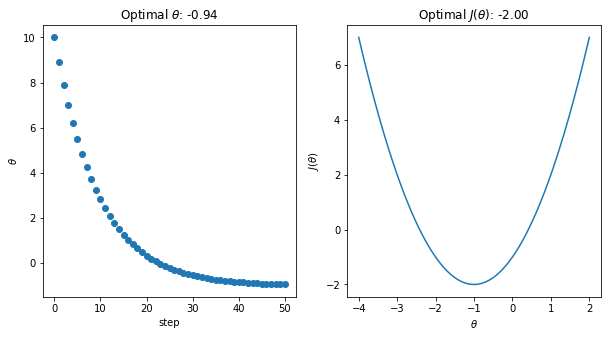

In [121]:
theta = 10
delta = 0.05
data = [theta]
for _ in range(50):
    theta = theta - delta * ( 2*theta + 2 )
    data.append(theta)
    
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(data, "o")
ax[0].set_title("Optimal $\\theta$: %.2f" % data[-1])
ax[0].set_xlabel("step")
ax[0].set_ylabel("$\\theta$")

th = np.linspace(-4,2,100)
ax[1].plot(th,th**2 + 2*th-1)
ax[1].set_title("Optimal $J(\\theta)$: %.2f" % (data[-1]**2 + 2*data[-1] - 1))
ax[1].set_xlabel("$\\theta$")
ax[1].set_ylabel("$J(\\theta)$");

Initial Output
 tensor([[0.0399],
        [0.0000],
        [0.0381],
        [0.0000]], grad_fn=<ReluBackward0>)
Final Output
 tensor([[0.],
        [1.],
        [1.],
        [0.]], grad_fn=<ReluBackward0>)


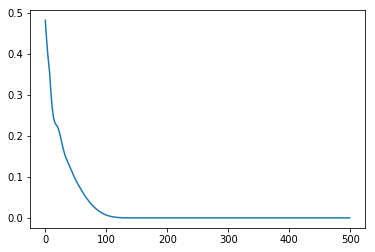

In [124]:
# Here is how to do gradient descent in pytorch.
# Note that this doesn't work very well (we'll fix it soon),
# so rerun this cell a few times to get it to output XOR.

model = Model(200)
x = torch.tensor([[0,0],[0,1],[1,0],[1,1]],dtype=torch.float, requires_grad=True)
y = torch.tensor([[0],[1],[1],[0]],dtype=torch.float)

print("Initial Output\n", model(x))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data = []

for n in range(500):
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat,y)
    data.append(loss)
    loss.backward() 
    optimizer.step()
    
plt.plot(data)

print("Final Output\n", model(x))

## Loss Functions

The Mean Squared Error is a reasonable choice for measuring the real valued difference between two functions. For classification problems, we would really like a model to output the probability that an input is of a certain class.

So the label of an input would be a probability distribution that assigns probability 1 to the proper class. The output of the model would be a probability distribution over the classes.

There are several ways to compare probability distributions $p$ and $q$. For example, the **total variation distance** and the **earth mover's distance**. For a variety of reasons, the **Cross Entropy** is a good choice:

$$
H(p,q) = \sum_x p(x) \log q(x)
$$

which measures the liklihood that a sample drawn from $q$ could have come from $p$. A related quantity is the **Kullbeck-Leibler Divergence:**

$$
D_\mathrm{KL}(P||Q) = \sum_x p(x) \log \frac{p(x)}{q(x)} .
$$

When $p=q$, $H(p,q) = H(p)$, the entropy of the distribution $p$, and $D_\mathrm{KL}(p||q) = 0$. 

Thus minimizing either pushes $q$ to be more like $p$. 

Text(0.5, 1.0, 'CE = 2.33, KL = 0.02')

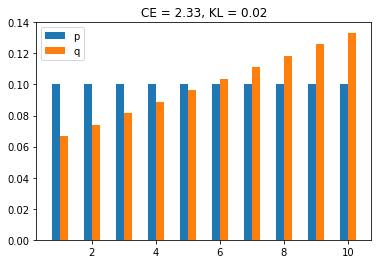

In [125]:
# Cross entropy abnd KL divergence of 

x = np.linspace(1,10,10)
p = np.ones(10) / 10
q = np.linspace(1,2,10)
q = q / sum(q)

# Cross Entropy of distribution q relative to p
# Measures how likley it is that a sample drawn from q
# could have come from p. When p = q, gives H(p).
ce = - np.sum(p * np.log(q))

# KL divergence measures how different q is from p.
# In coding theory, this would be the number of extra bits
# needed to encode samples from p given a code optimized for q.
kl = np.sum(p * np.log(p/q))

fig,ax=plt.subplots(1,1)
ax.bar(x-0.125,p,width=0.25, label="p");
ax.bar(x+0.125,q,width=0.25, label="q");
ax.legend()
ax.set_title("CE = %0.2f, KL = %0.2f" % (ce, kl))

# Improvements

The model we have made outputs numbers between 0 and $\infty$, but XOR takes values between 0 and 1. 

In a sense, XOR is **classifying** the input, saying whether it is in some class (1) or not (0).

To make the model output a classification, we will modify it so that 

$$
f(x;\theta) = \begin{pmatrix}
p_0 \\
p_1
\end{pmatrix}
$$

where $p_2 = 1 - p_1$. Thus, we are estimating the **probability** that the output is a 0 with $p_0$ and the probability the output is a $1$ with $p_1$. 

To compute the loss, we need to compare two probability distributions. The standard way to do this is the with **Cross Entropy** function:

$$
\mathrm{BCE}(p,\hat{p}) = - \sum_x p(x) \log \hat p(x),
$$

which is a comparison of the target probability distribution $p$ against the predicted distribution $\hat p$. 

As an example, suppose that the output of the network was 

$$\hat{y} = 
\begin{pmatrix}
0.5 & 0.5 \\
0.5 & 0.5 \\
0.5 & 0.5 \\
0.5 & 0.5 
\end{pmatrix} .
$$

For the first input, $(0,0)$, for example, the network is predicting that the $f(0,0)$ is 0 with probability of 0.5. 

The cross entropy averaged over all four output distributions is

$$
\frac{1}{4} \left ( 
  1 \cdot \log 0.5 + 0 \cdot \log 0.5 + 
  0 \cdot \log 0.5 + 1 \cdot \log 0.5 +
  0 \cdot \log 0.5 + 1 \cdot \log 0.5 + 
  1 \cdot \log 0.5 + 0 \cdot \log 0.5 
\right ) = 0.6931
$$

Now suppose that we are closer to the desired output with

$$\hat{y} = 
\begin{pmatrix}
0.9 & 0.1 \\
0.1 & 0.9 \\
0.1 & 0.9 \\
0.9 & 0.1 
\end{pmatrix} .
$$

This output has an average cross entropy of 

$$
\frac{1}{4} \left ( 
  1 \cdot \log 0.9 + 0 \cdot \log 0.1 + 
  0 \cdot \log 0.1 + 1 \cdot \log 0.9 +
  0 \cdot \log 0.1 + 1 \cdot \log 0.9 + 
  1 \cdot \log 0.9 + 0 \cdot \log 0.1 
\right ) = 0.3711 .
$$

In [126]:
# Using pytorch to compute cross entropy

criterion = nn.CrossEntropyLoss()

# The target classes

y = torch.tensor([
    0,
    1,
    1,
    0
])

# An example output
yhat =  torch.tensor([
    [0.5,0.5],
    [0.5,0.5],
    [0.5,0.5],
    [0.5,0.5] 
])
print(criterion(yhat,y))

# Another example output
yhat =  torch.tensor([
    [0.9,0.1],
    [0.1,0.9],
    [0.1,0.9],
    [0.9,0.1] 
])
print(criterion(yhat,y))


tensor(0.6931)
tensor(0.3711)


In [4]:
# A Better Model

class ModelTwo(nn.Module):
    def __init__(self,size):
        super(ModelTwo, self).__init__()
        self.fc1 = nn.Linear(2,size)
        self.fc2 = nn.Linear(size,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1) # Turns each output into a probability
                                         # distribution over {0,1}. In this case 
                                         # it returns (e^x1 e^x2) / ( e^x1 + e^x2 ). 
        return x

Initial Output
 tensor([[0.6011, 0.3989],
        [0.6366, 0.3634],
        [0.6698, 0.3302],
        [0.7104, 0.2896]], grad_fn=<SoftmaxBackward>)
Final Output
 tensor([[9.9981e-01, 1.9285e-04],
        [2.0645e-04, 9.9979e-01],
        [2.4812e-04, 9.9975e-01],
        [9.9973e-01, 2.7185e-04]], grad_fn=<SoftmaxBackward>)


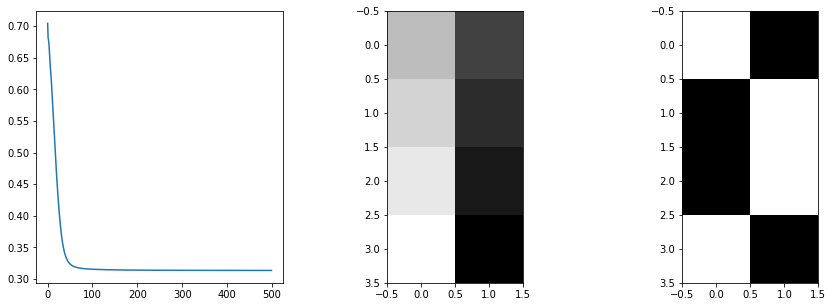

In [12]:
x = torch.tensor([[0,0],[0,1],[1,0],[1,1]],dtype=torch.float, requires_grad=True)
y = torch.tensor([0,1,1,0])

model = ModelTwo(100) # Ten neurons in the hidden layer helps assure that some reachable
                     # local minima computes the right function. In the trained model,
                     # some neurons may not do anything useful.

yhat0 = model(x)
print("Initial Output\n", yhat0)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

data = []

for n in range(500):
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat,y)
    data.append(loss)
    loss.backward() 
    optimizer.step()
    
fig,ax=plt.subplots(1,3,figsize=(15,5))

ax[0].plot(data)
ax[1].imshow(yhat0.detach().numpy(),cmap="gray")
ax[2].imshow(yhat.detach().numpy(),cmap="gray")
print("Final Output\n", yhat)

# A More General XOR Function

A somewhat more difficult and more realistic task is to learn the function

$$
f^*(x_1,x_2) = \left \{
\begin{array}{11}
1 & \mathrm{if} \; ( x_1 \leq \frac{1}{2} \wedge x_2 \leq \frac{1}{2}  ) \vee ( x_1 > \frac{1}{2} \wedge x_2 > \frac{1}{2}  ) \\
0 & \mathrm{otherwise} .
\end{array}
\right .
$$

This is harder because the input space is now $[0,1]^2$ instead of $\{0,1\}^2$. 

This is more realistic because there are an infinite number of possible training examples instead of just four.

To train a network with a lot of examples, one typically iterates the gradient descent algorithm with **batches** of input / output pairs. We suppose we have a large set of training data. In each iteration, we get a sample $M$ data points and follow the negative gradient on those. 

```python
for _ in range(200):
    x,y = make_data(100) 
    for _ in range(10):
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat,y)
        data.append(loss)
        loss.backward() 
        optimizer.step()
```

On a system with a GPU, we would copy the batch to the GPU and then run the gradient steps on the GPU. 

In [13]:
# Here is an example data set provider.
# Of course, normally this data would come from some experimental
# measurements. 

def make_data(n,p=1):
    
    x = torch.rand(n,2)
    x = x**p

    y = torch.tensor([
        (q[0]<1/3 and q[1]<1/3) or 
        (q[0]>2/3 and q[1]>2/3) or
        (q[0]>1/3 and q[0]<2/3 and q[1]>1/3 and q[1]<2/3) or
        (q[0]>0 and q[0]<1/3 and q[1]>2/3 and q[1]<1) or
        (q[1]>0 and q[1]<1/3 and q[0]>2/3 and q[0]<1) 
        for q in x
    ],dtype=torch.long)     
    
    return x,y

def show_predictions(model, ax):
    n = 1000
    x,y = make_data(n)
    yhat = model(x)
    prediction = torch.argmax(yhat,dim=1) 
    err = 100 * torch.sum(torch.abs(y - prediction)) / n
    p = ax.scatter(x[:,0], x[:,1], c=yhat[:,1].detach(), vmin=0, vmax=1)
    ax.set_aspect(1)  
    ax.set_title("%0.1f%% error" % err)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    plt.colorbar(p)

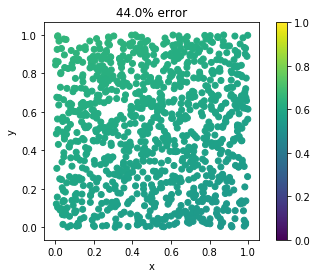

In [14]:
# Here, we instantiate the model and see what it outputs without training
model = ModelTwo(100)
show_predictions(model, plt.gca())

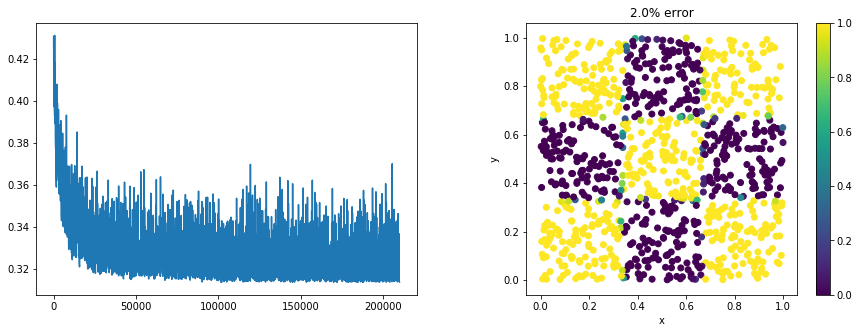

In [16]:
# Now we train the network and see what it does with new random data
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data = []

fig,ax=plt.subplots(1,2,figsize=(15,5))

for _ in range(1000):
    x,y = make_data(100) 
    for _ in range(10):
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat,y)
        data.append(loss)
        loss.backward() 
        optimizer.step()

ax[0].plot(data)
show_predictions(model, ax[1])

In [161]:
# A Deeper Model. Models that are deeper instead of wider often
# train faster or more accurately with the same number of neurons
# or connections.

class ModelThree(nn.Module):
    def __init__(self,size1, size2):
        super(ModelThree, self).__init__()
        self.fc1 = nn.Linear(2,size1)
        self.fc2 = nn.Linear(size1,size2)
        self.fc3 = nn.Linear(size2,2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1) # Turns each output into a probability
        return x                         # distribution over {0,1}
        

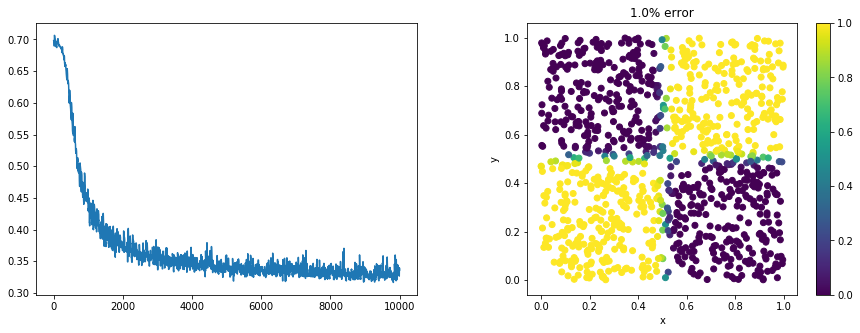

In [160]:
# Training the deeper model

model = ModelThree(10,5)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data = []

fig,ax=plt.subplots(1,2,figsize=(15,5))

for _ in range(1000):
    x,y = make_data(100) 
    for _ in range(10):
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat,y)
        data.append(loss)
        loss.backward() 
        optimizer.step()

ax[0].plot(data)
show_predictions(model, ax[1])

## Training Bias

Note that if you do not train a network with data that represents what you will use it to classify, then you might get bad results. For example, in the above we trained with random numbers between 0 and 1 uniformly. But what if we trained with numbers that were more likley to be close to zero?

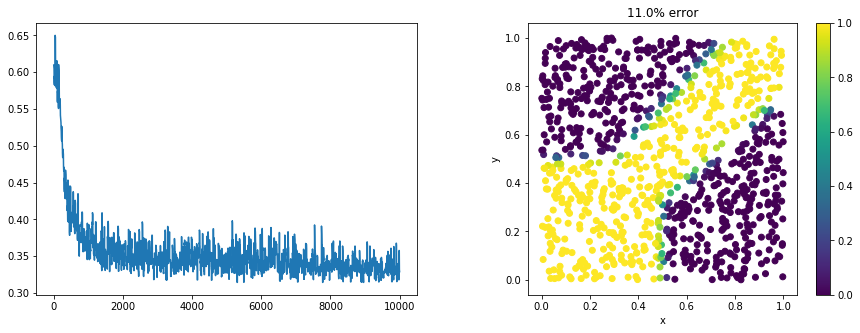

In [168]:
model = ModelThree(10,5)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

data = []

fig,ax=plt.subplots(1,2,figsize=(15,5))

for _ in range(1000):
    x,y = make_data(100,4) 
    for _ in range(10):
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat,y)
        data.append(loss)
        loss.backward() 
        optimizer.step()

ax[0].plot(data)
show_predictions(model, ax[1])